In [1]:
import pandas as pd
import numpy as np
from nltk import RegexpTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_auc_score, f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cves_tkr = RegexpTokenizer(r"cve-\d+-\d+|cve-\d+")


In [2]:
# pids = pd.read_csv("../Antichat/all_posts_with_cves.txt", sep=',', header=None)
# pids = pids.values[0]
# df = pd.read_csv("../Antichat/antichat.csv")
# df = df[df['IdPost'].isin(pids)]
# threads = df.sort_values(by='Timestamp').groupby("IdThread").first()
# threads.to_csv("../Antichat/threads.csv")
# with open("../Greysec/threads.txt", "w") as f:
#     list(map(lambda x: f.write(str(x) + ', '), threads.index))

In [3]:
df = pd.read_csv("posts_with_cve_in_Theading_or_content.csv", header=0, names=["IdPost", "Content", "PostAuthor", 
"Likes", "CitedPost", "Timestamp", "IdThread", "Heading", "ThreadAuthor", "Forum"])
df.head()

,IdPost,Content,PostAuthor,Likes,CitedPost,Timestamp,IdThread,Heading,ThreadAuthor,Forum
0,57353437,If you are looking for word exploit. detection...,3930754,0.0,{},2018-07-16 16:31:00-03,5786383,PDF/WORD/EXCEL silent mode exploit NEEDED!,3780954,10
1,57321760,***CITING***[https://hackforums.net/showthread...,3936927,0.0,{57320055},2018-07-09 02:36:00-03,5858996,How to choose exploit/payload,3936927,231
2,57306753,***CITING***[https://hackforums.net/showthread...,2096107,0.0,"{57260795,57263351,57271798,57281065,57265104,...",2018-07-05 14:14:00-03,5335859,TRILLIUM SECURITY MULTISPLOIT TOOL V6|FUD|0DAY...,2096107,374
3,57292155,***CITING***[https://hackforums.net/showthread...,2918763,0.0,{57291647},2018-07-02 04:47:00-03,5856664,Javascript 0DAY,3509175,163
4,57447902,***CITING***[https://hackforums.net/showthread...,2760444,0.0,{57447886},2018-08-09 04:11:40.019375-03,5871503,Priv esc win 10,3135692,231


In [4]:
df.shape

(3973, 10)

In [5]:
df['IdThread'].unique().shape

(1194,)

In [6]:
df['Heading'] = df['Heading'].astype(str).str.lower()
df['Content'] = df['Content'].astype(str).str.lower()

In [7]:
df['nCvesHeading'] = np.zeros(df.shape[0])
cols = df.columns
for i in range(len(df)):
    df.iloc[i, cols.get_loc('nCvesHeading')] = len(cves_tkr.tokenize(df.iloc[i, cols.get_loc('Heading')]))    

In [8]:
df[df['nCvesHeading'] > 0]['Heading']

5                anyone interested in exim cve-2018-6789?
6                      selling doc silent cve-2018 (.doc)
7                      selling doc silent cve-2018 (.doc)
8                      selling doc silent cve-2018 (.doc)
9                      selling doc silent cve-2018 (.doc)
                              ...                        
3960                          cve-2015-5119 (7th of july)
3967    cve-2014-6271 : remote code execution through ...
3968    cve-2014-6271 : remote code execution through ...
3969    cve-2014-6271 : remote code execution through ...
3970    cve-2014-6271 : remote code execution through ...
Name: Heading, Length: 2534, dtype: object

# With the ids of the threads, you should get all posts related to these special/interesting threads and finally get to work on this dataset with heuristics and ML

In [9]:
posts = pd.read_csv("posts_from_int_threads.csv", header=0, names=["IdPost", "Content", "PostAuthor", 
"Likes", "CitedPost", "Timestamp", "IdThread", "Heading", "ThreadAuthor", "Forum", 'NumPosts'])
posts['Content'] = posts['Content'].astype(str).str.lower()
print(posts.shape)
posts.head()

(48635, 11)


,IdPost,Content,PostAuthor,Likes,CitedPost,Timestamp,IdThread,Heading,ThreadAuthor,Forum,NumPosts
0,9282,"i found these, but how do i exploit them? \n\n...",1419,NaN,{-1},2007-12-15 21:25:00-02,3205,"Almost there, just need a little help. :)",1419,4,5
1,9285,i don't know but i want to hack my schools sma...,2388,NaN,{-1},2007-12-15 21:39:00-02,3205,"Almost there, just need a little help. :)",1419,4,5
2,9288,***quote***4mattc wrote:i don't know but i wan...,2453,NaN,{-1},2007-12-15 21:50:00-02,3205,"Almost there, just need a little help. :)",1419,4,5
3,9291,well mine is a little bit different. everyone ...,1419,NaN,{-1},2007-12-15 21:55:00-02,3205,"Almost there, just need a little help. :)",1419,4,5
4,9381,"4mattic you can do what xantos said, but you d...",2335,NaN,{-1},2007-12-16 04:11:00-02,3205,"Almost there, just need a little help. :)",1419,4,5


In [10]:
# Ordering posts by timestamp and getting the first post of each thread with group by
posts = posts.sort_values(by=['Timestamp'], ascending=True)
threads = posts.groupby('IdThread').first()

In [11]:
# now each row represents a thread with the important column: the content of its first post
threads.tail()

,IdPost,Content,PostAuthor,Likes,CitedPost,Timestamp,Heading,ThreadAuthor,Forum,NumPosts
IdThread,,,,,,,,,,
6018751,59080183,"hey fellas,\n\ni'm just wondering a website li...",4348717,0.0,{},2019-10-23 15:47:00-03,Can a website like this be hackable? ASP,4348717,48,10
6018833,59081058,howdy ya'''lllll!\n\ni am selling an exploit k...,4440013,0.0,{},2019-10-23 20:18:00-03,"CVE EXPLOIT KIT (MICROSOFT OFFICE, ADOBE FLASH...",4440013,176,12
6018960,59082490,guys where can i found this exploit?/>thankyou...,1373266,0.0,{},2019-10-24 08:20:00-03,CVE-2009-0993,1373266,43,5
6020023,59094213,by hacker icg\n\nnot for free this jex bot get...,3824046,0.0,{},2019-10-28 03:08:00-03,JEx Bot Exploiter mass world,3824046,10,1
6020442,59098182,it's not patched if owners don't update & i wo...,4119121,0.0,{},2019-10-29 12:42:29.207149-03,New PHP Flaw Could Let Attackers Hack Sites Ru...,4119121,89,2


In [12]:
# here I get the posts that are not the first of a thread but cite some CVE
posts['nCvesPost'] = np.zeros(posts.shape[0])
cols = posts.columns
posts['nCvesPost'] = posts['Content'].map(lambda x: len(cves_tkr.tokenize(x)))
special_posts = posts[(posts['nCvesPost'] > 0) & ~posts['IdPost'].isin(threads['IdPost'].unique())]
special_posts.shape

(975, 12)

In [13]:
tds_with_special_posts = pd.merge(threads, special_posts, on='IdThread', how='left').sort_values(by='IdThread')
print(tds_with_special_posts.shape)
tds_with_special_posts.head()

(1570, 22)


,IdThread,IdPost_x,Content_x,PostAuthor_x,Likes_x,CitedPost_x,Timestamp_x,Heading_x,ThreadAuthor_x,Forum_x,...,Content_y,PostAuthor_y,Likes_y,CitedPost_y,Timestamp_y,Heading_y,ThreadAuthor_y,Forum_y,NumPosts_y,nCvesPost
0,3205,9282,"i found these, but how do i exploit them? \n\n...",1419,NaN,{-1},2007-12-15 21:25:00-02,"Almost there, just need a little help. :)",1419,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9393,35583,can somedoby find exploit for smf 1.1.2 ?,1916,NaN,{-1},2008-01-04 09:41:00-02,SMF 1.1.2 Exploit,1916,4,...,you should already have this site in your book...,641.0,NaN,{-1},2008-01-04 12:44:00-02,SMF 1.1.2 Exploit,1916.0,4.0,3.0,2.0
2,9768,38826,"hi, iãƒâ€šã‚â´m sitting on a college where i l...",4397,NaN,{-1},2008-01-15 13:08:00-02,College see other computers?,4397,4,...,there is a really good easy to use program tha...,641.0,NaN,{-1},2008-01-15 13:22:00-02,College see other computers?,4397.0,4.0,9.0,1.0
3,14121,73495,ocãƒå¡craãƒâ¬$/ãƒâ€¹hã‚â® nujã‚âº,2103,NaN,{-1},2008-04-12 21:58:00-03,What is your Ctrl+V?,2103,25,...,***quote***ctrl+v wrote:***link***http://nvd.n...,9408.0,NaN,{-1},2008-06-03 15:26:00-03,What is your Ctrl+V?,2103.0,25.0,1599.0,2.0
4,24083,173390,"hello, i apologize now if this is in the wrong...",10018,NaN,{-1},2008-08-14 16:37:00-03,Get through a Router,10018,240,...,"any chance it's a linksys wrt54g? if so, you'...",9201.0,NaN,{-1},2008-08-14 16:44:00-03,Get through a Router,10018.0,240.0,23.0,2.0


In [14]:
from nltk.tokenize import word_tokenize

def words_in_text(words, text):
    return sum([1 if word in text else 0 for word in words])
poc = ['trillium', 'trill', 'trilli', 'tutorial', 'tut', 'penetration', 'pen', 
       'poc', 'proof-of-concept', 'proof of concept', 'guide']
weaponization = ['fud', 'bitcoin', 'price', 'pack', 'packs', 'buy', 'metasploit']
exploitation = ['pack', 'sell', 'trade']
help_posts = ['help']
money_regex = RegexpTokenizer(r'\$\s?\d{2,}')
def heuristics(text):
    tokenized = word_tokenize(text)
    if (words_in_text(poc, tokenized) > 0):
        return 'poc'
    elif (words_in_text(weaponization, tokenized) > 0):
        return 'weaponization'
    elif (words_in_text(exploitation, tokenized) > 0 or len(money_regex.tokenize(text)) > 0):
        return 'exploitation'
    elif (words_in_text(help_posts, tokenized) > 0):
        return 'help'
    else:
        return 'others'

In [15]:
# # Apply this very rough heuristics
# threads['Content'] = threads['Content'].astype(str).str.lower()
# threads['Heading'] = threads['Heading'].astype(str).str.lower()
# y = []
# for i in threads.index:
#     full_text = threads.loc[i, 'Content'] + '\n' + threads.loc[i, 'Heading']
#     y.append(heuristics(full_text))
# threads['label'] = y
# threads['label'].tail()    

In [16]:
# threads labeled
df = pd.read_csv("threads_crimebb_hackforums - threads_with_previouslabel_and_heristics.csv")
df['Content'] = df['Content'].astype(str).str.lower()
df['Heading'] = df['Heading'].astype(str).str.lower()
df['IdThread'] = df['IdThread'].astype('int64')
df['ActualLabelCode'] = df['ActualLabel'].map({'poc':0, 'weaponization':1, 'exploitation':2})
df = pd.merge(df, threads[['NumPosts']], left_on='IdThread', right_index=True)
df = df.set_index(['IdThread'])
df.head()

,IdPost,Heading,Content,label,PreviousLabel,ActualLabel,ActualLabelCode,NumPosts
IdThread,,,,,,,,
3205,9282,"almost there, just need a little help. :)","i found these, but how do i exploit them? \n\n...",help,weaponization,poc,0.0,5
9393,35583,smf 1.1.2 exploit,can somedoby find exploit for smf 1.1.2 ?,others,others,poc,0.0,3
9768,38826,college see other computers?,"hi, iãƒâ€šã‚â´m sitting on a college where i l...",others,error,poc,0.0,9
14121,73495,what is your ctrl+v?,ocãƒå¡craãƒâ¬$/ãƒâ€¹hã‚â® nujã‚âº,others,others,poc,0.0,1599
24083,173390,get through a router,"hello, i apologize now if this is in the wrong...",help,others,poc,0.0,23


In [17]:
notLab = sum(pd.isna(df['ActualLabel']))
print("missing: ", notLab)
print("labeled: ", len(df)-notLab)


missing:  126
labeled:  1067


In [18]:
sub_df = df[~pd.isna(df['ActualLabel']) & ~df['ActualLabel'].isin(['scam', 'warning', 'others', 'help'])]
sub_df.shape
# sub_df = sub_df['ActualLabel'].dropna()

(764, 8)

In [19]:
posts_from_threads_labeled = posts[posts['IdThread'].isin(sub_df.index)]    
print(posts_from_threads_labeled.shape)
posts_from_threads_labeled.head()

(34512, 12)


,IdPost,Content,PostAuthor,Likes,CitedPost,Timestamp,IdThread,Heading,ThreadAuthor,Forum,NumPosts,nCvesPost
0,9282,"i found these, but how do i exploit them? \n\n...",1419,NaN,{-1},2007-12-15 21:25:00-02,3205,"Almost there, just need a little help. :)",1419,4,5,2
1,9285,i don't know but i want to hack my schools sma...,2388,NaN,{-1},2007-12-15 21:39:00-02,3205,"Almost there, just need a little help. :)",1419,4,5,0
2,9288,***quote***4mattc wrote:i don't know but i wan...,2453,NaN,{-1},2007-12-15 21:50:00-02,3205,"Almost there, just need a little help. :)",1419,4,5,0
3,9291,well mine is a little bit different. everyone ...,1419,NaN,{-1},2007-12-15 21:55:00-02,3205,"Almost there, just need a little help. :)",1419,4,5,0
4,9381,"4mattic you can do what xantos said, but you d...",2335,NaN,{-1},2007-12-16 04:11:00-02,3205,"Almost there, just need a little help. :)",1419,4,5,0


In [20]:
# concatenation
sub_df['FullText'] = sub_df.index.map(lambda idThread: " ".join(posts[posts['IdThread'] == idThread]['Content']))

<ipython-input-20-77d7b339b618>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['FullText'] = sub_df.index.map(lambda idThread: " ".join(posts[posts['IdThread'] == idThread]['Content']))


In [21]:
from nltk.stem import PorterStemmer
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
ps = PorterStemmer()
# 1) removes accents; 2) remove punctuation; 3) sentiment feature; 4) tokenization; 5) remove stopwords; 6) stem
def preprocessText(df, column):
    stop_words = set(stopwords.words("english"))
    df[column] = df[column].str.lower()
    df[column] = df[column].map(lambda x: " ".join(e for e in x.split() if e.isalpha()))
    df[column] = df[column].map(lambda x: str(x).translate(str.maketrans(string.punctuation, " "*len(string.punctuation))))
    df[column] = df[column].map(lambda x: " ".join(e for e in x.split() if e.isalpha()))
    df['sentiment'+column] = df[column].map(lambda t: sid.polarity_scores(str(t))['compound'])
    df[column] = df[column].map(lambda t: nltk.word_tokenize(str(t)))
    df[column] = df[column].map(lambda t: list(filter(lambda x: x not in stop_words, t)))
#     df[column] = df[column].map(lambda t: [ps.stem(w) for w in t])

In [22]:
preprocessText(sub_df, 'Heading')

<ipython-input-21-85d6da8f4b28>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.lower()
<ipython-input-21-85d6da8f4b28>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].map(lambda x: " ".join(e for e in x.split() if e.isalpha()))
<ipython-input-21-85d6da8f4b28>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [23]:
preprocessText(sub_df, 'FullText')

<ipython-input-21-85d6da8f4b28>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.lower()
<ipython-input-21-85d6da8f4b28>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].map(lambda x: " ".join(e for e in x.split() if e.isalpha()))
<ipython-input-21-85d6da8f4b28>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [24]:
preprocessText(sub_df, 'Content')

<ipython-input-21-85d6da8f4b28>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.lower()
<ipython-input-21-85d6da8f4b28>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].map(lambda x: " ".join(e for e in x.split() if e.isalpha()))
<ipython-input-21-85d6da8f4b28>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [25]:
sub_df['ActualLabel'].value_counts()

weaponization    410
poc              247
exploitation     107
Name: ActualLabel, dtype: int64

In [26]:
def buildDoc2Vec(corpus):
    docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
    return Doc2Vec(docs, vector_size=100, window=2, min_count=2, epochs=100)

In [283]:
sub_df['LabelCode'] = sub_df['ActualLabel'].map({'poc': 0, 'weaponization': 0, 'exploitation':1})

<ipython-input-283-bab0a7145e87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['LabelCode'] = sub_df['ActualLabel'].map({'poc': 0, 'weaponization': 0, 'exploitation':1})


In [284]:
# values = under_df['LabelCode'].value_counts()
# values = y_over.value_counts()
# values = values.sort_index(ascending=True)
# ax = values.plot.barh(figsize=(12, 8), color=list('byr'))
# plt.rcParams.update({'font.size': 14})
# ax.set_yticklabels(['PoC', 'Weaponization', 'Exploitation'])

# total = values.sum()
# for p in ax.patches:
#     ax.annotate(str("{0:.0f}".format(p.get_width())), (p.get_width(), p.get_y()+0.2))
# plt.xlabel("Samples")
# plt.savefig("classes_distribution_over.png", format="png")

In [285]:
X = sub_df['FullText'].values.reshape(-1, 1)
y = sub_df['LabelCode']

In [286]:
# oversampling and undersampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
def overSample(X, y):
    oversample = RandomOverSampler(sampling_strategy='not majority')
    X_over, y_over = oversample.fit_resample(X, y)
    return (X_over, y_over)
def underSample(X, y):
    undersample = RandomUnderSampler()
    X_under, y_under = undersample.fit_resample(X, y)
    return (X_under, y_under)

In [287]:
from collections import Counter
X_over, y_over = overSample(X, y)
X_over = [x[0] for x in X_over]
X_under, y_under = underSample(X, y)
X_under = [x[0] for x in X_under]
print(Counter(y_over))
print(Counter(y_under))

Counter({0: 657, 1: 657})
Counter({0: 107, 1: 107})


In [300]:
modelOver.wv.most_similar(positive=['thanks', 'man'])

[('neglect', 0.46871811151504517),
 ('thank', 0.4600919783115387),
 ('stars', 0.4390716552734375),
 ('thx', 0.43315455317497253),
 ('paypals', 0.4308837354183197),
 ('bro', 0.4265841543674469),
 ('gong', 0.4260225296020508),
 ('cory', 0.4249363839626312),
 ('aduncous', 0.4247106611728668),
 ('instructional', 0.41656002402305603)]

In [289]:
modelUnder = buildDoc2Vec(X_under)

In [290]:
modelOver = buildDoc2Vec(X_over)

In [291]:
X_under_d2v = pd.concat([pd.DataFrame(modelUnder.docvecs.vectors_docs)])
X_over_d2v = pd.concat([pd.DataFrame(modelOver.docvecs.vectors_docs)])

In [292]:
# docvecs_full = np.array([modelFullText.infer_vector(doc) for doc in new_df['FullText']])
# docvecs_content = np.array([modelContent.infer_vector(doc) for doc in new_df['Content']])
# docvecs_heading = np.array([modelHeading.infer_vector(doc) for doc in new_df['Heading']])
# X = pd.concat([
#                 pd.DataFrame(docvecs_full).reset_index(drop=True), 
#                pd.DataFrame(docvecs_heading).reset_index(drop=True), 
#                pd.DataFrame(sub_df['sentiment']).reset_index(drop=True),
#                pd.DataFrame(sub_df['NumPosts']).reset_index(drop=True),
#               ], axis=1, ignore_index=True)
# X = docvecs_full

# X = pd.concat([new_df['sentimentFullText'].reset_index(drop=True), 
#                pd.DataFrame(docvecs_full)], axis=1)

svc = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)
clf.fit(X_over_d2v, y_over)
print(clf.best_score_)
# print(cross_val_score(clf.best_estimator_, X_over, y_over, cv=10).mean())

0.9809798856413086


In [261]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X_over_d2v, y_over)
clf = SVC(C=10, kernel='rbf')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(accuracy_score(y_test, predicted))
# print(precision_score(y_test, predicted))

0.6146341463414634


Text(0, 0.5, 'Polarity')

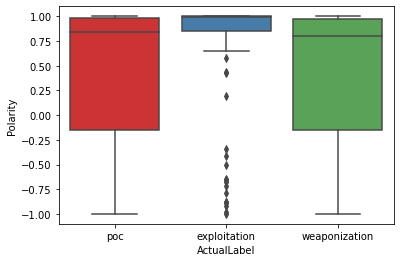

In [263]:
sns.boxplot(x='ActualLabel', y='sentimentFullText', data=sub_df, palette="Set1")
plt.ylabel("Polarity")

In [264]:
# TF-IDF

def tfIdf(docs):
    english_stopwords = set(stopwords.words('english'))
    tfidf_para = {
        "stop_words": english_stopwords,
        "analyzer": 'word',
        "token_pattern": r'\w{1,}',
        "sublinear_tf": True,
        "dtype": np.float32,
        "norm": 'l2',
        #"min_df":5,
        #"max_df":.9,
        "smooth_idf":False
    }
    vectorizer = TfidfVectorizer(**tfidf_para, ngram_range=(1, 1))
    tfidf = vectorizer.fit_transform(docs)
    tfvocab = vectorizer.get_feature_names()
    return tfidf, tfvocab, vectorizer


In [265]:
tfidf_matrix, vocab, vectorizer = tfIdf([" ".join(doc) for doc in X_over])

In [266]:
from sklearn.feature_selection import VarianceThreshold
p = 0
# p = 0.00015
fsel = VarianceThreshold(threshold=(p * (1 - p)))
selected = fsel.fit_transform(tfidf_matrix)
selected


<820x27787 sparse matrix of type '<class 'numpy.float32'>'
	with 181198 stored elements in Compressed Sparse Row format>

In [267]:
filtered_words = pd.DataFrame(vocab).iloc[fsel.get_support(True)]
filtered_words= [w[0] for w in filtered_words.values]

In [268]:
len(filtered_words)

27787

In [269]:
# X = sub_df['sentimentFullText'].values.reshape(-1, 1)
# # X = tfidf
# y = sub_df['LabelCode']
# # clf = SVC()
# clf = AdaBoostClassifier()
# print(cross_val_score(clf, X, y, cv=5).mean())

In [270]:
import graphviz
# X = hstack((tfidf_matrix[:, fsel.get_support(True)], X_over['sentimentFullText'].values.reshape(-1,1)))
X = tfidf_matrix[:, fsel.get_support(True)]
decision_tree = tree.DecisionTreeClassifier()
parameters = {'max_depth': np.arange(2, 10), 'min_samples_split': np.arange(3, 10), 'min_samples_leaf':np.arange(3, 5) }
clf = GridSearchCV(decision_tree, parameters, cv=5, n_jobs=-1)
clf.fit(X, y_over)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([3, 4]),
                         'min_samples_split': array([3, 4, 5, 6, 7, 8, 9])})

In [271]:
clf.best_score_

0.5987804878048781

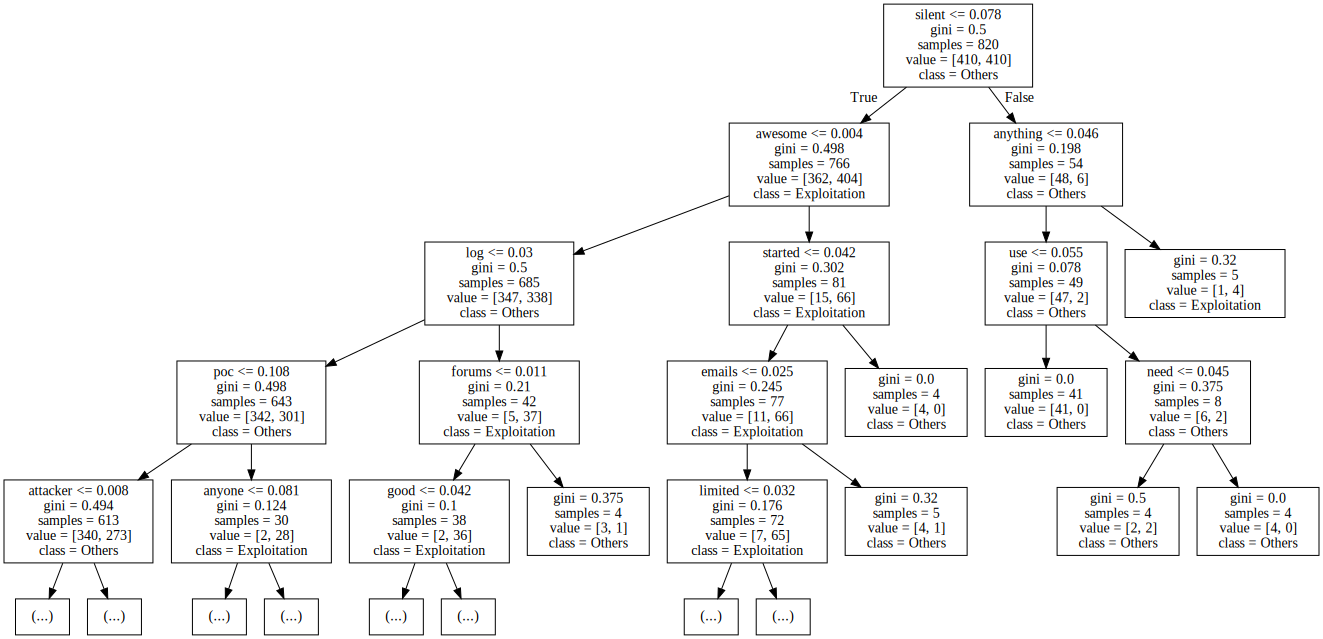

In [272]:
dot_data = tree.export_graphviz(clf.best_estimator_, feature_names=filtered_words,
                                class_names=['Others', 'Exploitation'], 
#                                 class_names=['PoC', 'Weaponization', 'Exploitation'],
                                out_file=None,
                                max_depth=4
                                )
graph = graphviz.Source(dot_data, format="png")
graph

In [273]:
# graph.render("tree_undersampling")

In [274]:
graph.render("trees/tree_oversampling_2classes_weap_vs_all")

'trees/tree_oversampling_2classes_weap_vs_all.png'

In [381]:
graph.render("tree_after_filtering_only_sentiment")

'tree_after_filtering_only_sentiment.png'

In [38]:
offensivecomm = pd.read_csv("../OffensiveCommunity/threads_labeled.csv")
offensivecomm = offensivecomm[offensivecomm['Label'].isin(['weaponization', 'poc', 'exploitation'])]
offensivecomm = offensivecomm.dropna(subset=['Label'])
preprocessText(offensivecomm, 'Content')
offensivecomm.head()

,IdThread,Label,IdPost,Author,Thread,Timestamp,Content,AuthorNumPosts,AuthorReputation,LastParse,...,AuthorName-2,Forum,Heading,NumPosts,LastParse-2,URL,parsed-2,NumPages,Direction,sentimentContent
0,452,weaponization,800,148,452,2012-12-27 05:33:00-02,"[linux, exploit]",533,3,2017-04-07 11:58:47.681658-03,...,Pratham,26,Linux 2.6.18-194 2010 Local root,1,2017-04-07 11:58:47.690672-03,http://offensivecommunity.net/thread-452.html,True,1,FORWARD,-0.1027
1,716,poc,1046,148,716,2013-04-05 23:18:00-03,"[root, exploit, centrify, deployment, manager,...",533,3,2017-04-07 08:41:18.133065-03,...,Pratham,26,Local Root Exploit 2.1.0.283,4,2017-04-07 08:41:18.141485-03,http://offensivecommunity.net/thread-716.html,True,1,FORWARD,0.2682
3,1000,exploitation,2215,5485,1000,2013-07-30 03:01:00-03,"[exploit, samsung, tv, denial, service, attack...",49,0,2017-04-07 11:58:00.20237-03,...,DeadManIndia,26,Exploit Title: Samsung TV Denial of Service (D...,6,2018-04-12 07:57:11.400808-03,http://offensivecommunity.net/showthread.php?t...,True,1,BACKWARD,0.3612
5,1751,exploitation,6618,17405,1751,2014-11-23 03:01:00-02,"[nice, nigguh, check, shitz, lol, run, interne...",60,0,2017-04-07 12:35:42.01166-03,...,aabee,36,A Virus That Will Open And Close Ur Cdrom,2,2017-04-07 12:35:42.240206-03,http://offensivecommunity.net/thread-1751.html,True,1,FORWARD,-0.9584
6,2010,poc,6614,17405,2010,2014-11-23 03:47:00-02,"[dve, copy, yuange, exploit, sub, dim, shell, ...",60,0,2017-04-07 08:42:02.407078-03,...,tutmoses,26,Ie exploit fun,1,2017-04-07 08:42:02.416313-03,http://offensivecommunity.net/thread-2010.html,True,1,FORWARD,-0.9393


In [39]:
posts_ofc = pd.read_csv("../OffensiveCommunity/posts.csv")
posts_ofc.head()

,IdPost,Content,Author,Likes,CitedPost,Timestamp,IdThread,Heading,Author-2,Forum
0,800,Linux exploit 2.6.18-194 2010\n\nCode:***CITIN...,148,NaN,{-1},2012-12-27 05:33:00-02,452,Linux 2.6.18-194 2010 Local root,148,26
1,1046,/*Local root exploit for Centrify Deployment M...,148,NaN,{-1},2013-04-05 23:18:00-03,716,Local Root Exploit 2.1.0.283,148,26
2,2175,FOSCAM IP-Cameras Improper Access Restrictions...,1,NaN,{-1},2013-07-24 00:27:00-03,978,Exploit - FOSCAM IP-Cameras Improper Access Re...,1,26
3,2215,Code:#!/usr/bin/python\n\n# Exploit Title: Sam...,5485,NaN,{-1},2013-07-30 03:01:00-03,1000,Exploit Title: Samsung TV Denial of Service (D...,5485,26
4,2204,Thanks bro\n\t\n\t\n\t\n\nread rules before ad...,5485,NaN,{-1},2013-07-31 04:48:00-03,1000,Exploit Title: Samsung TV Denial of Service (D...,5485,26


In [40]:
offensivecomm['FullText'] = offensivecomm['IdThread'].map(lambda idThread: " ".join(posts_ofc[posts_ofc['IdThread'] == idThread]['Content']))

In [41]:
preprocessText(offensivecomm, 'FullText')

In [76]:
X_ofc = [modelUnder.infer_vector(doc) for doc in offensivecomm['FullText']]
y_ofc = offensivecomm['Label'].map({'weaponization': 0, 'poc': 0, 'exploitation':1})

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_ofc, y_ofc)
clf = SVC(C=10, kernel='rbf')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(accuracy_score(y_test, predicted))
print(precision_score(y_test, predicted))

0.8333333333333334
0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
svc = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)
clf.fit(X_ofc, y_ofc)
print(clf.best_score_)

0.8800000000000001


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [76]:
posts_antichat = pd.read_csv("../Antichat/posts_translated.csv")
antichat = pd.read_csv("../Antichat/threads_antichat_translated_first_post.csv")
antichat = antichat[antichat['Label'].isin(['weaponization', 'poc', 'exploitation'])]
antichat = antichat.dropna(subset=['Label'])
preprocessText(antichat, 'Content_en')
antichat['FullText'] = antichat['IdThread'].map(lambda idThread: " ".join(posts_antichat[posts_antichat['IdThread'] == idThread]['Content_en']))
preprocessText(antichat, 'FullText')
antichat.head()

,IdThread,IdPost,Heading_en,Content_en,Author,Label,sentimentContent_en,FullText,sentimentFullText
0,12520,96068,New XSS on phpBB 2.0.19 forum,"[phpbb, xss, securityalert, medium, remote, ye...",18692,exploitation,0.9531,"[phpbb, xss, securityalert, medium, remote, ye...",0.9927
1,18262,143919,Html script for downloading a virus to a remot...,"[maybe, someone, posted, opinion, script, gold...",18829,exploitation,0.6585,"[maybe, someone, posted, opinion, script, gold...",0.9789
2,24423,197747,"Apache <1.3.37, 2.0.59, 2.2.3 (mod_rewrite) Re...","[bin, sh, exploit, apache, vulnerability, disc...",19011,weaponization,0.5563,"[bin, sh, exploit, apache, vulnerability, disc...",0.5849
3,24465,198119,"Exploits for browsers (IE, Mozilla, Opera, Chr...",[],26719,weaponization,0.0000,"[add, tired, ask, everyone, join, ok, waiting,...",0.9944
4,25540,208410,Another question about vulnerabilities in phpb...,"[knows, crack, phpbb, know, xss, included, htm...",27645,poc,-0.4748,"[knows, crack, phpbb, know, xss, included, htm...",0.9745


In [77]:
X_antichat = [modelUnder.infer_vector(doc) for doc in antichat['FullText']]
y_antichat = antichat['Label'].map({'weaponization': 0, 'poc': 0, 'exploitation':1})

svc = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)
clf.fit(X_antichat, y_antichat)
print(clf.best_score_)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.8333333333333333


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_antichat, y_antichat)
clf = SVC()
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(accuracy_score(y_test, predicted))
print(precision_score(y_test, predicted))

1.0
0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
vectorizer.transform(antichat['FullText'][0]).toarray().shape

(328, 27787)

In [106]:
antichat['FullText'][0]

['phpbb',
 'xss',
 'securityalert',
 'medium',
 'remote',
 'yes',
 'local',
 'exploit',
 'yes',
 'maksymilian',
 'arciemowicz',
 'affected',
 'phpbb',
 'prior',
 'advisory',
 'begin',
 'pgp',
 'signed',
 'message',
 'xss',
 'maksymilian',
 'arciemowicz',
 'phpbb',
 'high',
 'fully',
 'highly',
 'customizable',
 'open',
 'source',
 'bulletin',
 'boar',
 'phpbb',
 'simple',
 'straightforward',
 'administration',
 'helpful',
 'based',
 'powerful',
 'php',
 'server',
 'language',
 'choice',
 'mysql',
 'postgresql',
 'access',
 'odbc',
 'database',
 'phpbb',
 'ideal',
 'free',
 'community',
 'lution',
 'web',
 'contact',
 'author',
 'xss',
 'phpbb',
 'allowed',
 'html',
 'tags',
 'like',
 'pre',
 'profile',
 'al',
 'low',
 'yes',
 'guest',
 'issue',
 'phpbb',
 'old',
 'exploit',
 'x',
 'c',
 'onmouseover',
 'x',
 'h',
 'e',
 'l',
 'new',
 'exploit',
 'x',
 'c',
 'onmouseover',
 'x',
 'b',
 'exploits',
 'simillar',
 'notice',
 'replaced',
 'new',
 'version',
 'phpbb',
 'filter',
 'use',
 'c'

In [92]:
# Apply decision tree
X_antichat = [vectorizer.transform(t) for t in antichat['FullText']]
y_antichat = antichat['Label'].map({'weaponization': 0, 'poc': 0, 'exploitation':1})

clf.predict(X_antichat)

ValueError: setting an array element with a sequence.